# Лабораторная работа №5

In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.style.use('ggplot')
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns

import math
from sklearn import preprocessing

In [10]:
# import os
# os.chdir("C:/Users/вячеслав/Desktop/Lab_01/Lab_01/")

In [8]:
# df = pd.read_excel('default of credit card clients.xls', header=1, index_col=0)
df = pd.read_excel('default of credit card clients.xls', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
df.shape

(30000, 25)

(25.5, -0.5)

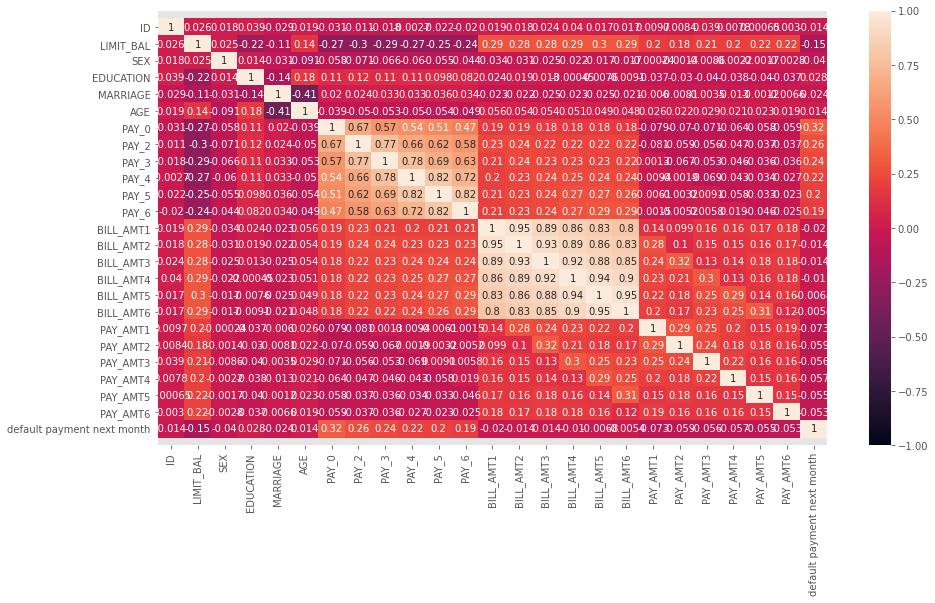

In [12]:
df_corr = df.corr()

plt.figure(figsize=(15,8))
ax = sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [13]:
df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

Видим, что классы не сбалансированы.

In [14]:
y = df['default payment next month']
X = df.drop(columns=['default payment next month'])

In [15]:
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


Сделаем обучающие и тестовые выборки

In [16]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
grid_param = {  
    'n_estimators': [500],
    'max_depth': [3]
}

In [63]:
grid_search_res = GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, seed=1234, 
                               
       objective='binary:logistic',                  
       colsample_bylevel=1, colsample_bytree=0.8, subsample=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, 
       min_child_weight=1, missing=None, nthread=-1,
       reg_alpha=0, reg_lambda=1, 
       scale_pos_weight=1), n_jobs=-1,
       param_grid=grid_param,
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [64]:
grid_search_res.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=1234, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3], 'n_estimators': [500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy

In [65]:
print("Best params on dev set:")
print(grid_search_res.best_params_)

Best params on dev set:
{'max_depth': 3, 'n_estimators': 500}


In [73]:
y_pred_train = grid_search_res.predict(X_train)
y_pred_test = grid_search_res.predict(X_test)

In [67]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

,0,1
0,7326,354
1,899,1321


In [68]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

,0,1
0,15226,458
1,1464,2952


Строим предсказание модели.

In [69]:
y_pred_train2 = grid_search_res.predict_proba(X_train)
y_pred_test2 = grid_search_res.predict_proba(X_test)
print(y_pred_train2)
print(y_pred_test2)

[[0.9787651  0.02123494]
 [0.9709744  0.02902564]
 [0.9695255  0.0304745 ]
 ...
 [0.712792   0.28720802]
 [0.9757728  0.0242272 ]
 [0.64008313 0.35991687]]
[[0.83910507 0.16089492]
 [0.9550096  0.04499044]
 [0.95053464 0.04946533]
 ...
 [0.9730354  0.02696458]
 [0.9638043  0.03619572]
 [0.8383645  0.16163549]]


In [70]:
y_pred_train2 = grid_search_res.predict(X_train)
y_pred_test2 = grid_search_res.predict(X_test)
print(metrics.classification_report(y_pred_test2, y_test))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      8225
           1       0.60      0.79      0.68      1675

    accuracy                           0.87      9900
   macro avg       0.77      0.84      0.80      9900
weighted avg       0.89      0.87      0.88      9900



In [71]:
from sklearn.metrics import accuracy_score
print("Accuracy on train set is ", accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  90.43781094527364
Accuracy on test set is  87.34343434343434


In [72]:
fi = pd.DataFrame({'features': X_train.columns, 'importance': grid_search_res.best_estimator_.feature_importances_})
fi.sort_values('importance', ascending=False).head(10)

,features,importance
6,PAY_0,0.126184
25,F2,0.098917
15,BILL_AMT4,0.060751
16,BILL_AMT5,0.059135
12,BILL_AMT1,0.047243
11,PAY_6,0.040605
1,LIMIT_BAL,0.040428
24,F1,0.039294
18,PAY_AMT1,0.037288
14,BILL_AMT3,0.034327


## Факторный анализ

In [30]:
pip install factor_analyzer

     |████████████████████████████████| 40kB 4.0MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40383 sha256=bf192f414779cbd6401fbd256edbd1c3d3129d32f436b6beacb0235732fb47c1
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


In [32]:
from factor_analyzer import FactorAnalyzer

In [33]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='minres', 
                    impute='mean', is_corr_matrix=False)

In [34]:
df_scaled = preprocessing.StandardScaler().fit_transform(df)
df_scaled[0:5, :]

array([[-1.73199307, -1.13672015,  0.81016074,  0.18582826, -1.05729503,
        -1.24601985,  1.79456386,  1.78234817, -0.69666346, -0.66659873,
        -1.53004603, -1.48604076, -0.64250107, -0.64739923, -0.66799331,
        -0.67249727, -0.66305853, -0.65272422, -0.34194162, -0.22708564,
        -0.29680127, -0.30806256, -0.31413612, -0.29338206,  1.87637834],
       [-1.7318776 , -0.3659805 ,  0.81016074,  0.18582826,  0.85855728,
        -1.02904717, -0.87499115,  1.78234817,  0.1388648 ,  0.18874609,
         0.23491652,  1.99231551, -0.65921875, -0.66674657, -0.63925429,
        -0.62163594, -0.60622927, -0.59796638, -0.34194162, -0.21358766,
        -0.24000461, -0.24422965, -0.31413612, -0.18087821,  1.87637834],
       [-1.73176213, -0.59720239,  0.81016074,  0.18582826,  0.85855728,
        -0.16115646,  0.01486052,  0.1117361 ,  0.1388648 ,  0.18874609,
         0.23491652,  0.25313738, -0.29855966, -0.49389911, -0.48240819,
        -0.44973025, -0.41718767, -0.39162956, -0

In [35]:
fa.fit(df_scaled)

FactorAnalyzer(bounds=(0.005, 1), impute='mean', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [36]:
df_scaled.shape

(30000, 25)

In [37]:
fa.loadings_

array([[ 0.03284699, -0.02233943],
       [ 0.45215149, -0.3656146 ],
       [-0.00859931, -0.07060213],
       [-0.04883505,  0.14375131],
       [-0.04760202,  0.04567588],
       [ 0.08533494, -0.06631999],
       [-0.00938722,  0.68421187],
       [ 0.01000459,  0.816484  ],
       [ 0.00902047,  0.8500368 ],
       [ 0.02093438,  0.86560556],
       [ 0.0448641 ,  0.84278152],
       [ 0.06799639,  0.77606166],
       [ 0.85651969,  0.2504168 ],
       [ 0.88972522,  0.26852408],
       [ 0.9082901 ,  0.266671  ],
       [ 0.91972543,  0.27498098],
       [ 0.90908363,  0.27532564],
       [ 0.88302147,  0.26760984],
       [ 0.30778013, -0.07532774],
       [ 0.26838788, -0.08117745],
       [ 0.29516629, -0.08786229],
       [ 0.26958423, -0.08552724],
       [ 0.26172071, -0.08327014],
       [ 0.24325125, -0.0789279 ],
       [-0.10304959,  0.29441934]])

In [38]:
 fa.get_communalities()

array([0.00157797, 0.338115  , 0.00505861, 0.0230493 , 0.00435224,
       0.01168039, 0.46823401, 0.66674622, 0.72264393, 0.74971124,
       0.71229348, 0.60689521, 0.79633456, 0.86371615, 0.89610433,
       0.92150941, 0.90223725, 0.85134194, 0.10040288, 0.07862183,
       0.09484292, 0.07999056, 0.07543165, 0.06540079, 0.09730196])

In [39]:
fa.get_uniquenesses()

array([0.99842203, 0.661885  , 0.99494139, 0.9769507 , 0.99564776,
       0.98831961, 0.53176599, 0.33325378, 0.27735607, 0.25028876,
       0.28770652, 0.39310479, 0.20366544, 0.13628385, 0.10389567,
       0.07849059, 0.09776275, 0.14865806, 0.89959712, 0.92137817,
       0.90515708, 0.92000944, 0.92456835, 0.93459921, 0.90269804])

In [40]:
fa.get_communalities() + fa.get_uniquenesses()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
faLoadingsV = pd.DataFrame(np.vstack((fa.loadings_.T, fa.get_uniquenesses())),
                          index = ['Factor 1', 'Factor 2', 'Уникальность'], 
                           columns = list(df.columns.values))
faLoadingsV.round(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
Factor 1,0.033,0.452,-0.009,-0.049,-0.048,0.085,-0.009,0.010,0.009,0.021,0.045,0.068,0.857,0.890,0.908,0.920,0.909,0.883,0.308,0.268,0.295,0.270,0.262,0.243,-0.103
Factor 2,-0.022,-0.366,-0.071,0.144,0.046,-0.066,0.684,0.816,0.850,0.866,0.843,0.776,0.250,0.269,0.267,0.275,0.275,0.268,-0.075,-0.081,-0.088,-0.086,-0.083,-0.079,0.294
Уникальность,0.998,0.662,0.995,0.977,0.996,0.988,0.532,0.333,0.277,0.250,0.288,0.393,0.204,0.136,0.104,0.078,0.098,0.149,0.900,0.921,0.905,0.920,0.925,0.935,0.903


In [42]:
zzz = fa.transform(df_scaled)
zzz

array([[-0.78547592, -0.11176382],
       [-0.85445582,  0.68233867],
       [-0.56480799,  0.19740024],
       ...,
       [-0.87066115,  1.26891643],
       [ 0.27144745, -0.06899771],
       [-0.21547451,  0.30899787]])

In [43]:
factors_2 = pd.DataFrame(fa.transform(df_scaled), columns = ['F1', 'F2'])
factors_2.head(5)

,F1,F2
0,-0.785476,-0.111764
1,-0.854456,0.682339
2,-0.564808,0.197400
3,-0.226062,0.235627
4,-0.320197,-0.107256


In [44]:
df_full = df.merge(factors_2, left_index=True, right_index=True)

df_full.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,F1,F2
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,-0.785476,-0.111764
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,-0.854456,0.682339
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,-0.564808,0.197400
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,-0.226062,0.235627
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-0.320197,-0.107256


In [45]:
df_full.corr("pearson").iloc[0:24, [25, 26]]

,F1,F2
ID,0.033421,-0.023208
LIMIT_BAL,0.460058,-0.379824
SEX,-0.008750,-0.073346
EDUCATION,-0.049689,0.149338
MARRIAGE,-0.048434,0.047451
AGE,0.086827,-0.068897
PAY_0,-0.009551,0.710803
PAY_2,0.010180,0.848216
PAY_3,0.009178,0.883073
PAY_4,0.021300,0.899247


In [46]:
pd.DataFrame(fa.loadings_)

,0,1
0,0.032847,-0.022339
1,0.452151,-0.365615
2,-0.008599,-0.070602
3,-0.048835,0.143751
4,-0.047602,0.045676
5,0.085335,-0.066320
6,-0.009387,0.684212
7,0.010005,0.816484
8,0.009020,0.850037
9,0.020934,0.865606


In [47]:
y = df_full['default payment next month']
X = df_full.drop(columns=['default payment next month'])

In [50]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [52]:
grid_search_res = GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, seed=1234, 
                               
       objective='binary:logistic',                  
       colsample_bylevel=1, colsample_bytree=0.8, subsample=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, 
       min_child_weight=1, missing=None, nthread=-1,
       reg_alpha=0, reg_lambda=1, 
       scale_pos_weight=1), n_jobs=-1,
       param_grid=grid_param,
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [53]:
grid_search_res.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=1234, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3], 'n_estimators': [500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy

In [54]:
print("Best params on dev set:")
print(grid_search_res.best_params_)

Best params on dev set:
{'max_depth': 3, 'n_estimators': 500}


In [55]:
y_pred_train = grid_search_res.predict(X_train)
y_pred_test = grid_search_res.predict(X_test)

In [56]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

,0,1
0,7326,354
1,899,1321


In [57]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

,0,1
0,15226,458
1,1464,2952


In [58]:
y_pred_train2 = grid_search_res.predict_proba(X_train)
y_pred_test2 = grid_search_res.predict_proba(X_test)
print(y_pred_train2)
print(y_pred_test2)

[[0.9787651  0.02123494]
 [0.9709744  0.02902564]
 [0.9695255  0.0304745 ]
 ...
 [0.712792   0.28720802]
 [0.9757728  0.0242272 ]
 [0.64008313 0.35991687]]
[[0.83910507 0.16089492]
 [0.9550096  0.04499044]
 [0.95053464 0.04946533]
 ...
 [0.9730354  0.02696458]
 [0.9638043  0.03619572]
 [0.8383645  0.16163549]]


In [60]:
y_pred_train2 = grid_search_res.predict(X_train)
y_pred_test2 = grid_search_res.predict(X_test)
print(metrics.classification_report(y_pred_test2, y_test))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      8225
           1       0.60      0.79      0.68      1675

    accuracy                           0.87      9900
   macro avg       0.77      0.84      0.80      9900
weighted avg       0.89      0.87      0.88      9900



In [61]:
from sklearn.metrics import accuracy_score
print("Accuracy on train set is ", accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  90.43781094527364
Accuracy on test set is  87.34343434343434


Видим хороший результат accuracy, поэтому остановимся на 2-х факторах.

In [62]:
fi = pd.DataFrame({'features': X_train.columns, 'importance': grid_search_res.best_estimator_.feature_importances_})
fi.sort_values('importance', ascending=False).head(10)

,features,importance
6,PAY_0,0.126184
25,F2,0.098917
15,BILL_AMT4,0.060751
16,BILL_AMT5,0.059135
12,BILL_AMT1,0.047243
11,PAY_6,0.040605
1,LIMIT_BAL,0.040428
24,F1,0.039294
18,PAY_AMT1,0.037288
14,BILL_AMT3,0.034327
